[*********************100%***********************]  2 of 2 completed
Weekly CAGR: 30.69%


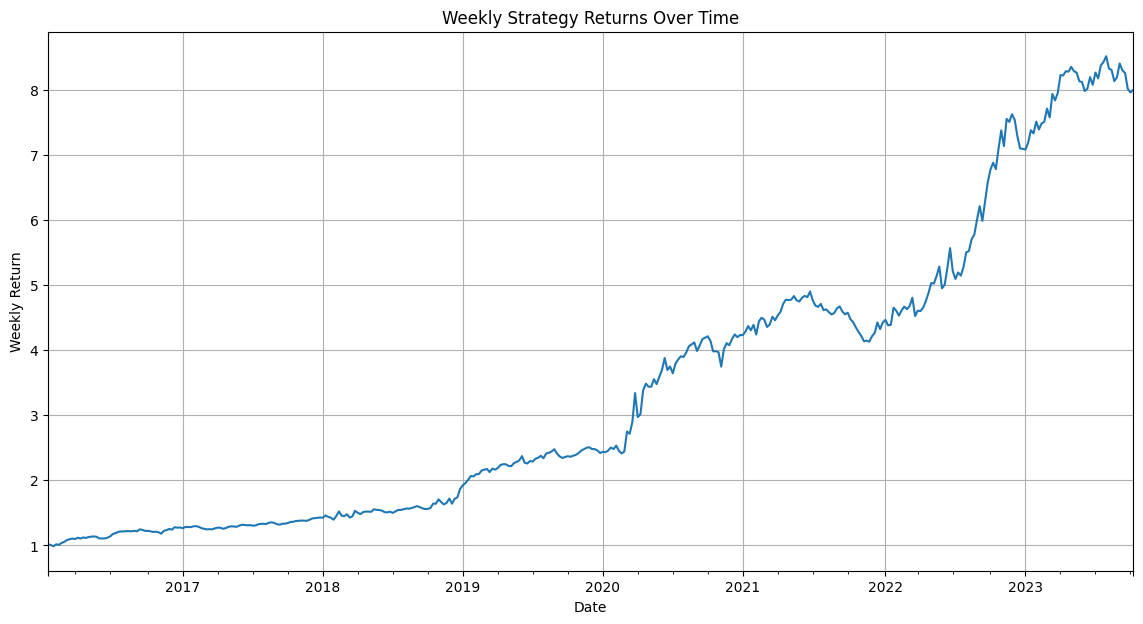

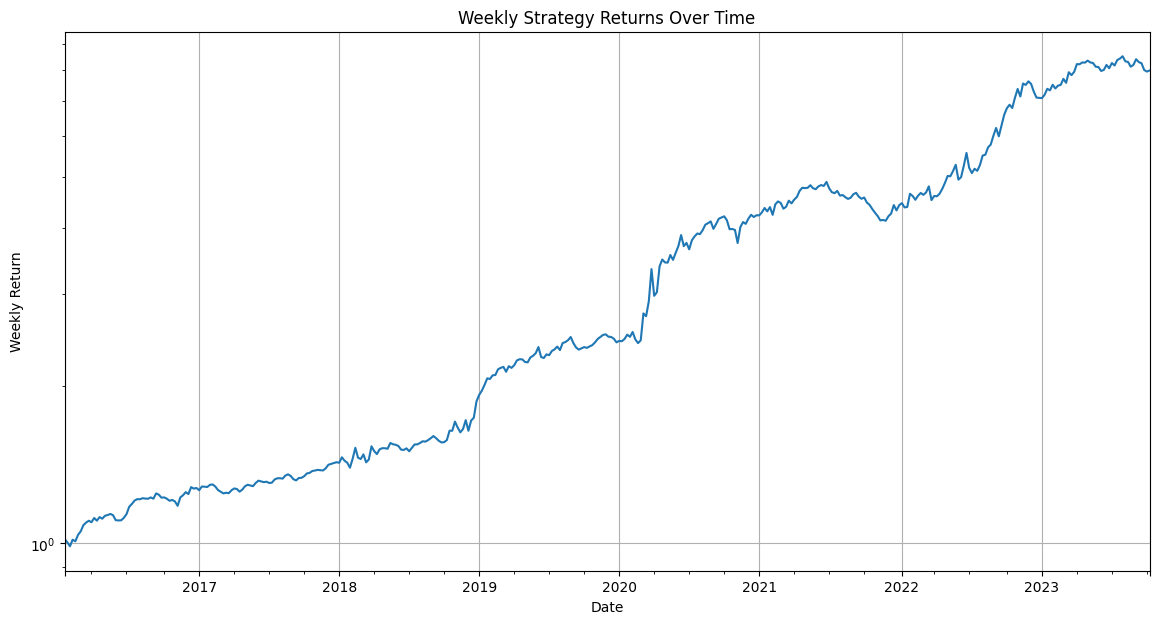

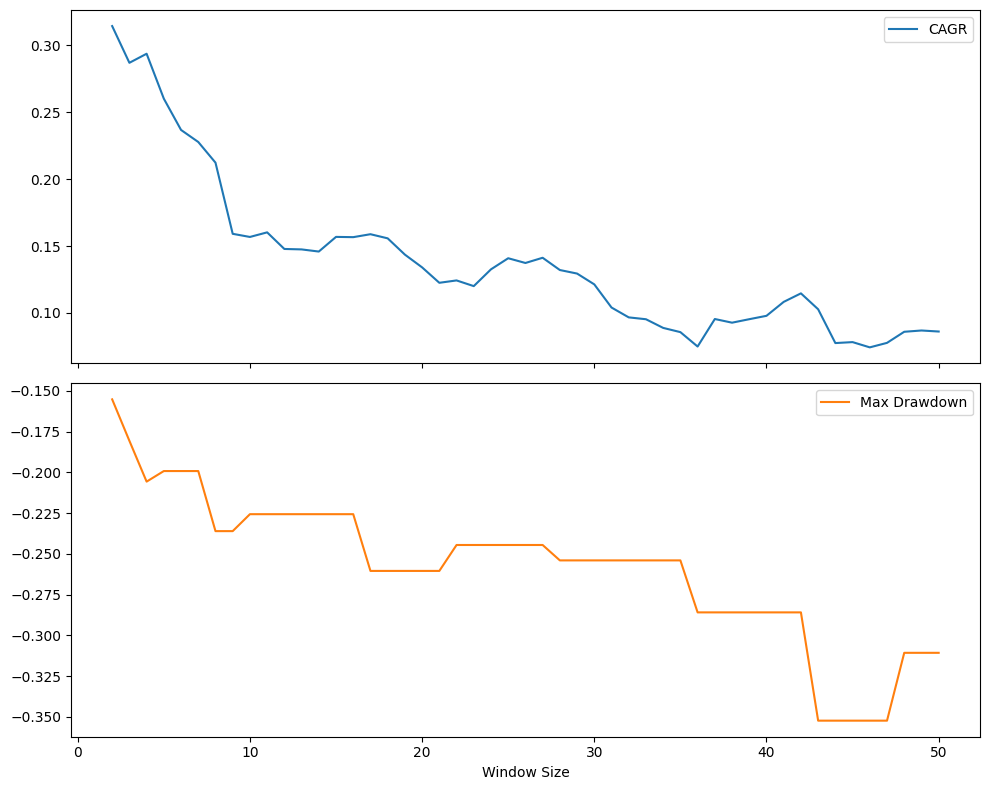

Strategy on Test Data: CAGR: 44.12%


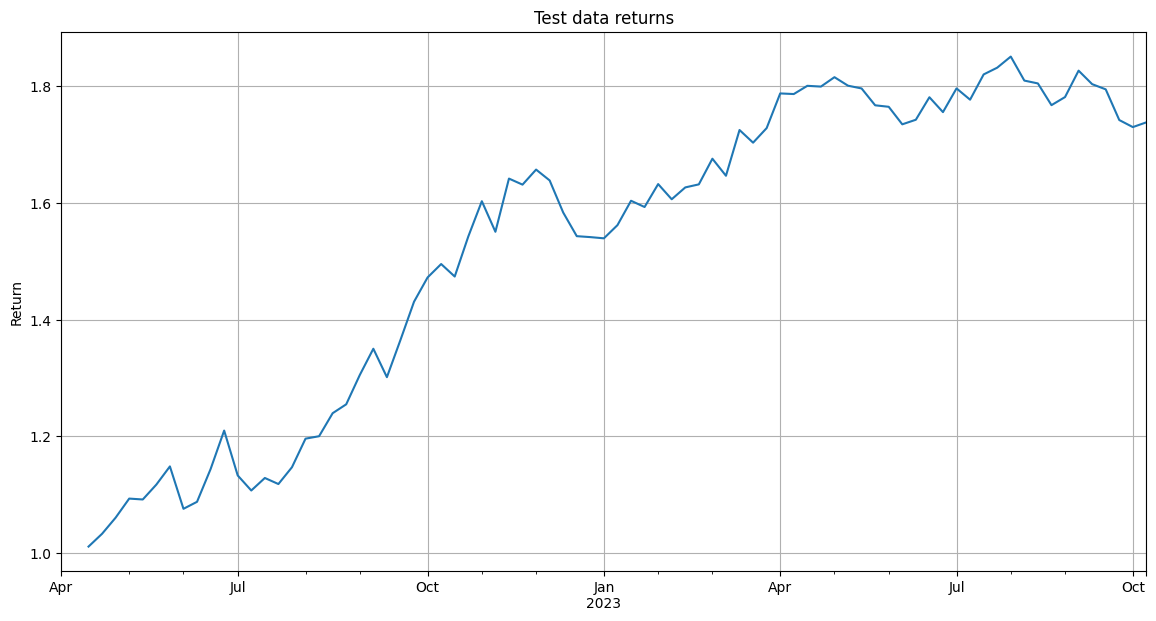

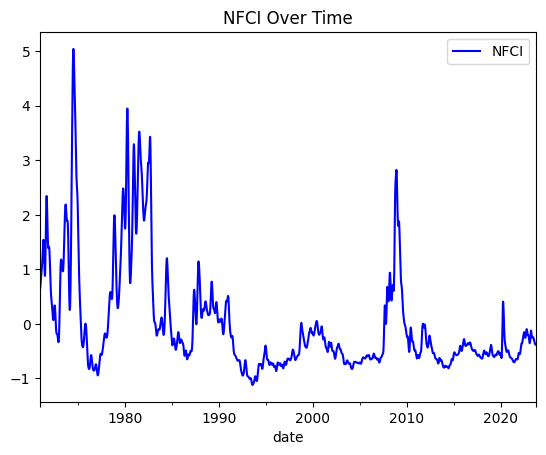

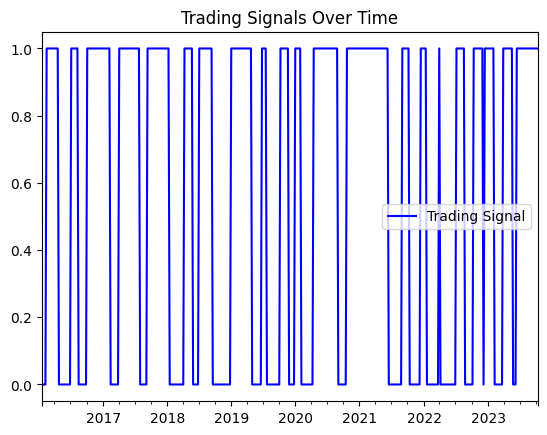

Latest Date: 2023-10-13 00:00:00, Latest Signal Value: 1
Correlation between SPY and SH: -0.9953
Annual Returns:
2016    0.282639
2017    0.125720
2018    0.313241
2019    0.302877
2020    0.757499
2021    0.050739
2022    0.611353
2023    0.132214
Name: strategy_returns, dtype: float64


In [9]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

# Read the data
nfci_data = pd.read_csv('nfci.csv')
nfci_data['date'] = pd.to_datetime(nfci_data['DATE'])
nfci_data.set_index('date', inplace=True)

# Calculate the 14-day moving average
nfci_data['nfci_sma_14'] = nfci_data['NFCI'].rolling(window=2).mean()
# Shift the 14-day moving average by one day
nfci_data['nfci_sma_14_shifted'] = nfci_data['nfci_sma_14'].shift(1)

# Download SPY and SH data
symbols = ['SPY','SH']
prices_data = yf.download(symbols, start='2016-01-03', end=nfci_data.index.max())['Close']
prices_data = prices_data.resample("W-FRI").last()

# Saving trade log
prices_data.to_csv('prices_data.csv')

# Merge the dataframes
data = prices_data.join(nfci_data, how='inner')

# Create a signal
data['signal'] = np.where(data['NFCI'] < data['nfci_sma_14_shifted'], 1, 0)

# Calculate strategy returns
data['strategy_returns'] = np.where(data['signal'] == 1, data['SPY'].shift(1).pct_change(), data['SH'].shift(1).pct_change())
data['SPY_returns'] = data['SPY'].pct_change()
data['cumulative_strategy_returns'] = (1 + data['strategy_returns']-0.0001).cumprod()
# Calculate the total period in years
total_years = (data.index[-1] - data.index[0]).days / 365.0
# Calculate CAGR using the final cumulative return value
end_value = data['cumulative_strategy_returns'].iloc[-1]
cagr_weekly = (end_value) ** (1 / total_years) - 1

print(f"Weekly CAGR: {cagr_weekly*100:.2f}%")

# Drop missing values
data.dropna(inplace=True)
# Plotting weekly strategy returns

plt.figure(figsize=(14, 7))
data['cumulative_strategy_returns'].plot()
plt.title('Weekly Strategy Returns Over Time')
plt.ylabel('Weekly Return')
plt.xlabel('Date')
plt.grid(True)
plt.show()

# Plotting weekly strategy returns
plt.figure(figsize=(14, 7))
data['cumulative_strategy_returns'].plot()
plt.title('Weekly Strategy Returns Over Time')
plt.ylabel('Weekly Return')
plt.yscale("log")
plt.xlabel('Date')
plt.grid(True)
plt.show()

def evaluate_strategy(window_size, data):
    data['nfci_sma'] = data['NFCI'].rolling(window=window_size).mean()
    data['nfci_sma_shifted'] = data['nfci_sma'].shift(1)
    data['signal'] = np.where(data['NFCI'] < data['nfci_sma_shifted'], 1, 0)
    data['strategy_returns'] = np.where(data['signal'] == 1, data['SPY'].shift(1).pct_change(), data['SH'].shift(1).pct_change())
    
    years = (data.index[-1] - data.index[0]).days / 365.0
    cagr_strategy = (1 + data['strategy_returns']).cumprod().iloc[-1] ** (1 / years) - 1
    cumulative_returns_strategy = (1 + data['strategy_returns']).cumprod()
    rolling_max_strategy = cumulative_returns_strategy.expanding().max()
    daily_drawdown_strategy = cumulative_returns_strategy / rolling_max_strategy - 1
    max_drawdown_strategy = daily_drawdown_strategy.min()
    
    return {
        'Window Size': window_size,
        'CAGR': cagr_strategy,
        'Max Drawdown': max_drawdown_strategy
    }

# Loop over different window sizes (from 2 to 50, for instance)
results = []
for window in range(2, 51):
    result = evaluate_strategy(window, data.copy())
    results.append(result)
results_df = pd.DataFrame(results)

# Optional: plot the results to visualize them
results_df.set_index('Window Size').plot(subplots=True, figsize=(10, 8))
plt.tight_layout()
plt.show()

# Splitting data into training (80%) and test (20%)
train_size = int(0.8 * len(data))
train_data = data.iloc[:train_size].copy()  # use .copy() to create a copy
test_data = data.iloc[train_size:].copy()   # use .copy() to create a copy


# Strategy design on training data
# For simplicity, let's stick with your 2-day moving average. However, you'd ideally want to test multiple periods here.
train_data['nfci_sma_14'] = train_data['NFCI'].rolling(window=2).mean()
train_data['nfci_sma_14_shifted'] = train_data['nfci_sma_14'].shift(1)
train_data['signal'] = np.where(train_data['NFCI'] < train_data['nfci_sma_14_shifted'], 1, 0)
train_data['strategy_returns'] = np.where(train_data['signal'] == 1, train_data['SPY'].shift(1).pct_change(), train_data['SH'].shift(1).pct_change())

# Applying strategy to test data
test_data['nfci_sma_14'] = test_data['NFCI'].rolling(window=2).mean()
test_data['nfci_sma_14_shifted'] = test_data['nfci_sma_14'].shift(1)
test_data['signal'] = np.where(test_data['NFCI'] < test_data['nfci_sma_14_shifted'], 1, 0)
test_data['strategy_returns'] = np.where(test_data['signal'] == 1, test_data['SPY'].shift(1).pct_change(), test_data['SH'].shift(1).pct_change())


years = (test_data.index[-1] - test_data.index[0]).days / 365.0
cagr_strategy = (1 + test_data['strategy_returns']).cumprod().iloc[-1] ** (1 / years) - 1

print(f"Strategy on Test Data: CAGR: {cagr_strategy:.2%}")
test_data['cumulative_strategy_returns'] = (1 + test_data['strategy_returns']-0.0001).cumprod()
# Plotting weekly strategy returns
plt.figure(figsize=(14, 7))
test_data['cumulative_strategy_returns'].plot()
plt.title('Test data returns')
plt.ylabel('Return')
plt.grid(True)
plt.show()

# Determine where trades take place (i.e., where the signal changes)
data['trade_executed'] = data['signal'].diff().abs()
# Apply transaction costs on the days trades are executed

# Display the list of all trades with their date
trade_dates = data[data['trade_executed'] == 1].index

# Create a dataframe for the trade log
trade_log = pd.DataFrame(columns=['Start Date', 'End Date', 'Asset', 'Entry Price', 'Exit Price'])

# Iterate over the data to identify trades and record them in the trade log
current_position = None
entry_price = None
for i, row in data.iterrows():
    if row['trade_executed'] == 1:
        if current_position:  # If there's a current position, record the exit trade
            trade_data = pd.DataFrame({
                'Start Date': [trade_start],
                'End Date': [i],
                'Asset': [current_position],
                'Entry Price': [entry_price],
                'Exit Price': [row[current_position]]
            })
            trade_log = pd.concat([trade_log, trade_data], ignore_index=True)
        
        # Update current position and trade start
        current_position = 'SPY' if row['signal'] == 1 else 'SH'
        trade_start = i
        entry_price = row[current_position]
        
# Plot the NFCI value over time
nfci_data['NFCI'].plot(label='NFCI', color='b')
plt.title('NFCI Over Time')
plt.legend()
plt.show()

# Plot the trading signals over time
data['signal'].plot(label='Trading Signal', color='b')
plt.title('Trading Signals Over Time')
plt.legend()
plt.show()

# Get the latest date and value
latest_date = data.index[-1]
latest_value = data['signal'].iloc[-1]

# Print the latest date and value
print(f"Latest Date: {latest_date}, Latest Signal Value: {latest_value}")

correlation = data['SPY'].pct_change().corr(data['SH'].pct_change())
print(f"Correlation between SPY and SH: {correlation:.4f}")


# Determine where trades take place (i.e., where the signal changes)
data['trade_executed'] = data['signal'].diff().abs()

# Create a dataframe for the trade log
trade_log = pd.DataFrame(columns=['Start Date', 'End Date', 'Asset', 'Entry Price', 'Exit Price'])

# Iterate over the data to identify trades and record them in the trade log
current_position = None
entry_price = None
trade_start = None
for i, row in data.iterrows():
    if row['trade_executed'] == 1:
        if current_position:  # If there's a current position, record the exit trade
            trade_data = pd.DataFrame({
                'Start Date': [trade_start],
                'End Date': [i],
                'Asset': [current_position],
                'Entry Price': [entry_price],
                'Exit Price': [row[current_position]]
            })
            trade_log = pd.concat([trade_log, trade_data], ignore_index=True)
        
        # Update current position and trade start
        current_position = 'SPY' if row['signal'] == 1 else 'SH'
        trade_start = i
        entry_price = row[current_position]

# Output the trade log to a text file
trade_log.to_csv('trade_log.txt', sep='\t', index=False)

# Calculate annual returns
annual_returns = (data['strategy_returns'] + 1).groupby(data.index.year).prod() - 1

# Display annual returns
print("Annual Returns:")
print(annual_returns)